In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
!unzip "/content/drive/MyDrive/Collab Notebook/dataset.zip" -d "/content/drive/MyDrive/Collab Notebook"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_1020.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0458.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0504.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0262.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0276.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_1168.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0510.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_0538.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_1140.jpg  
  inflating: /content/drive/MyDrive/Collab Notebook/dataset/Training/notumor/Tr-no_1154.jpg  
  inflati

In [46]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [47]:
import zipfile
zip_path = "/content/drive/MyDrive/Collab Notebook/dataset.zip"   # ubah ke nama file kamu
extract_path = "/content/drive/MyDrive/Collab Notebook"  # folder tempat hasil unzip

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Done! File berhasil di-unzip.")

Done! File berhasil di-unzip.


In [48]:
train_data_path = '/content/drive/MyDrive/Collab Notebook/dataset/Testing'

filepaths = []
labels = []

folders = os.listdir(train_data_path)

for folder_name in folders:
  f_path = os.path.join(train_data_path , folder_name)
  if os.path.isdir(f_path):
    for file in os.listdir(f_path):
      filelist = os.path.join(f_path , file)
      filepaths.append(filelist)
      labels.append(folder_name)

# Concat data.paths with labels after collecting all data
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [49]:
train_data_path = '/content/drive/MyDrive/Collab Notebook/dataset/Training'

filepaths = []
labels = []

folders = os.listdir(train_data_path)

for folder_name in folders:
  f_path = os.path.join(train_data_path , folder_name)
  if os.path.isdir(f_path):
    for file in os.listdir(f_path):
      filelist = os.path.join(f_path , file)
      filepaths.append(filelist)
      labels.append(folder_name)

# Concat data.paths with labels after collecting all data
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'labels')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [50]:
valid , test = train_test_split(train_df , test_size = 0.5 , shuffle = True , stratify = train_df['labels'] , random_state = 42)

In [51]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


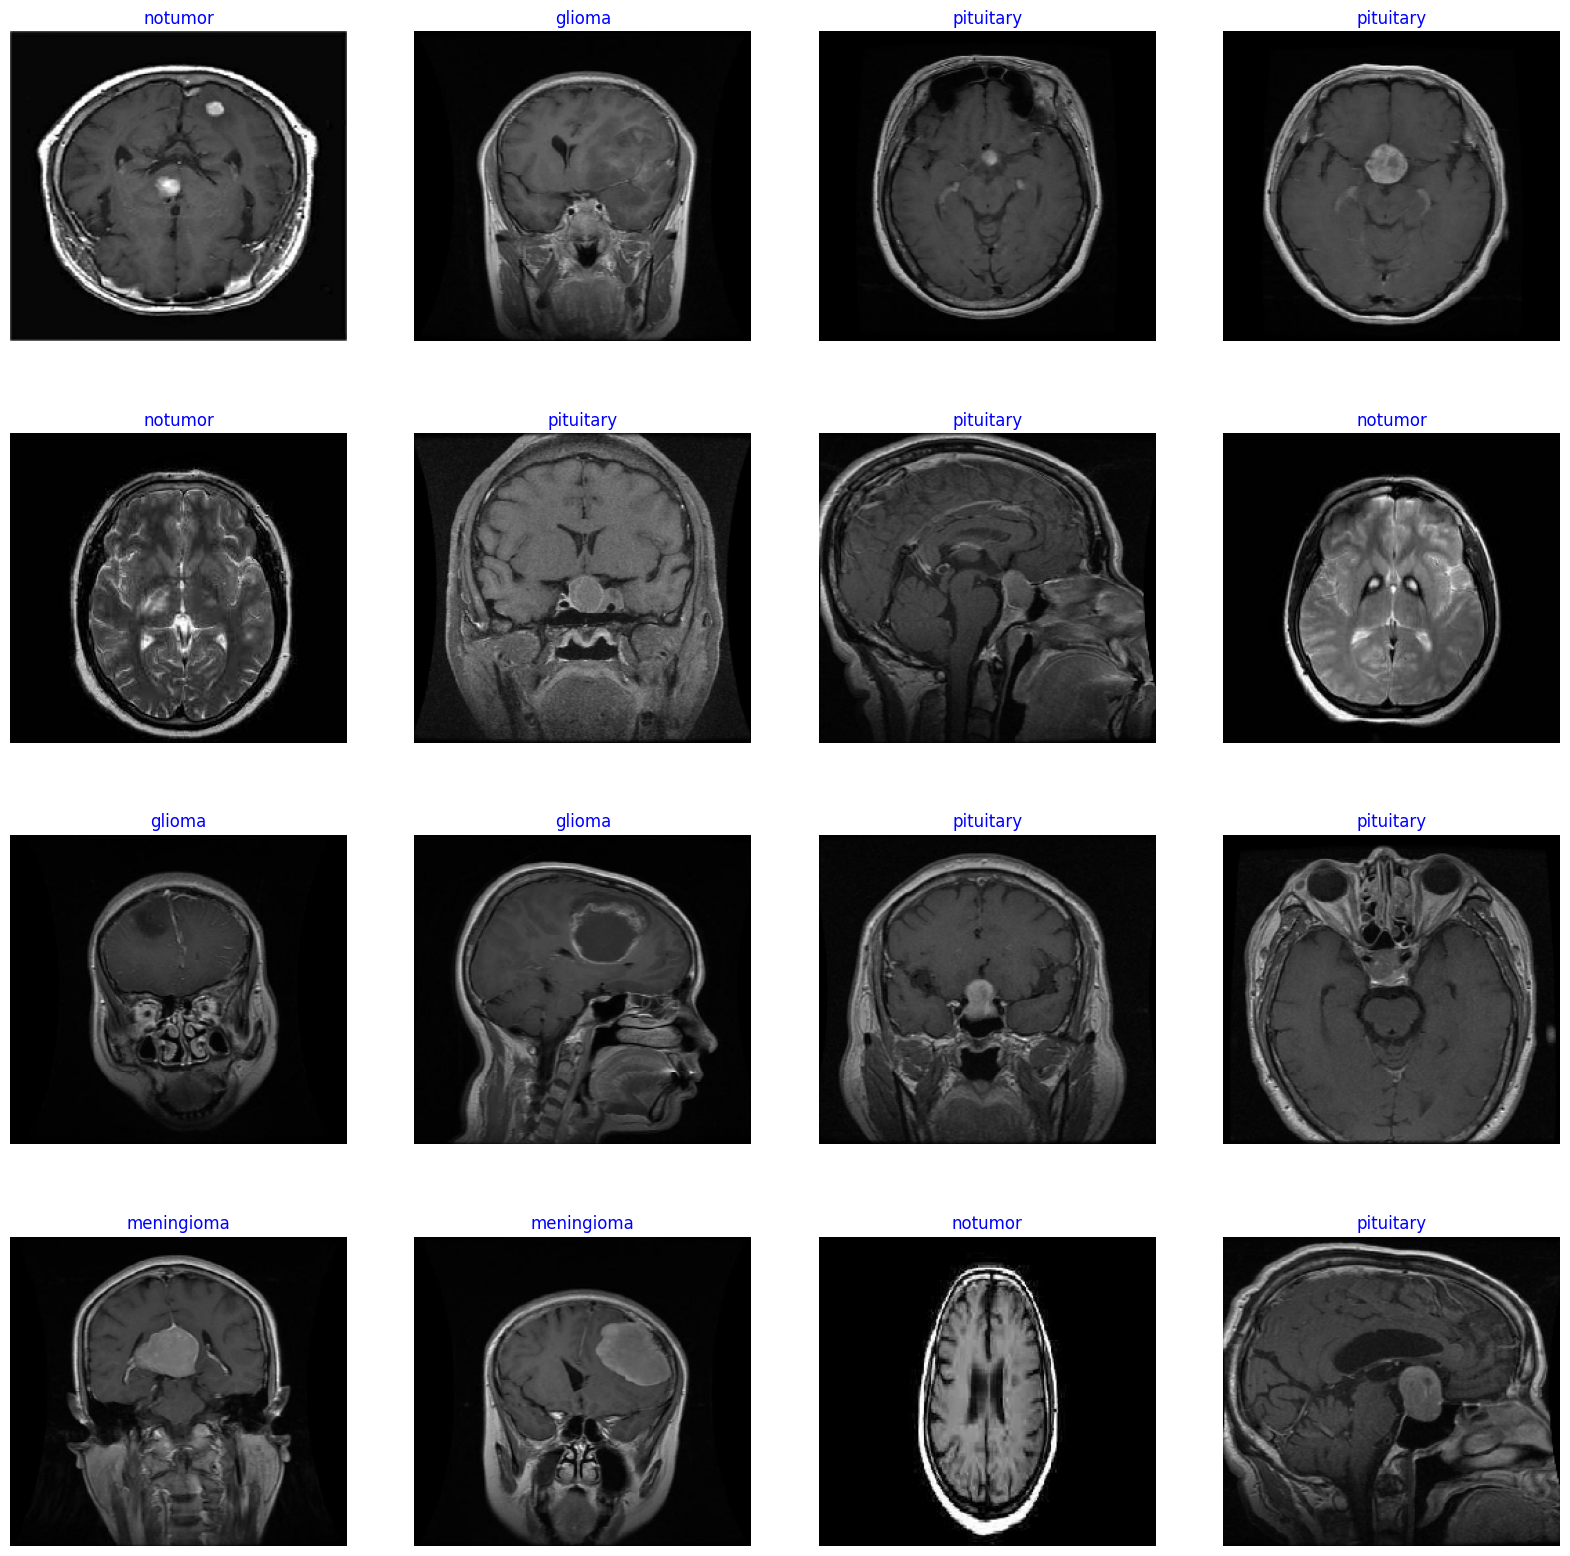

In [52]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

In [53]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

In [54]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs = Epochs,
    verbose = 1,
    validation_data = valid_gen,
    shuffle = True
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 170s 229ms/step - accuracy: 0.5603 - loss: 10.5905 - val_accuracy: 0.3676 - val_loss: 5.4126
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 140ms/step - accuracy: 0.3457 - loss: 4.9061 - val_accuracy: 0.3253 - val_loss: 3.6441
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 51s 142ms/step - accuracy: 0.3332 - loss: 3.3403 - val_accuracy: 0.3113 - val_loss: 2.5714
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - accuracy: 0.4841 - loss: 2.3617 - val_accuracy: 0.7241 - val_loss: 1.8061
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - accuracy: 0.7382 - loss: 1.7230 - val_accuracy: 0.9062 - val_loss: 1.2997
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 139ms/step - accuracy: 0.8557 - loss: 1.3145 - val_accuracy: 0.9489 - val_loss: 0.9658
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.8840 - loss: 1.0723 - val_accuracy: 0.9716 - val_loss: 0.7736
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 50s 139ms/step - accuracy: 0.9031 - loss:

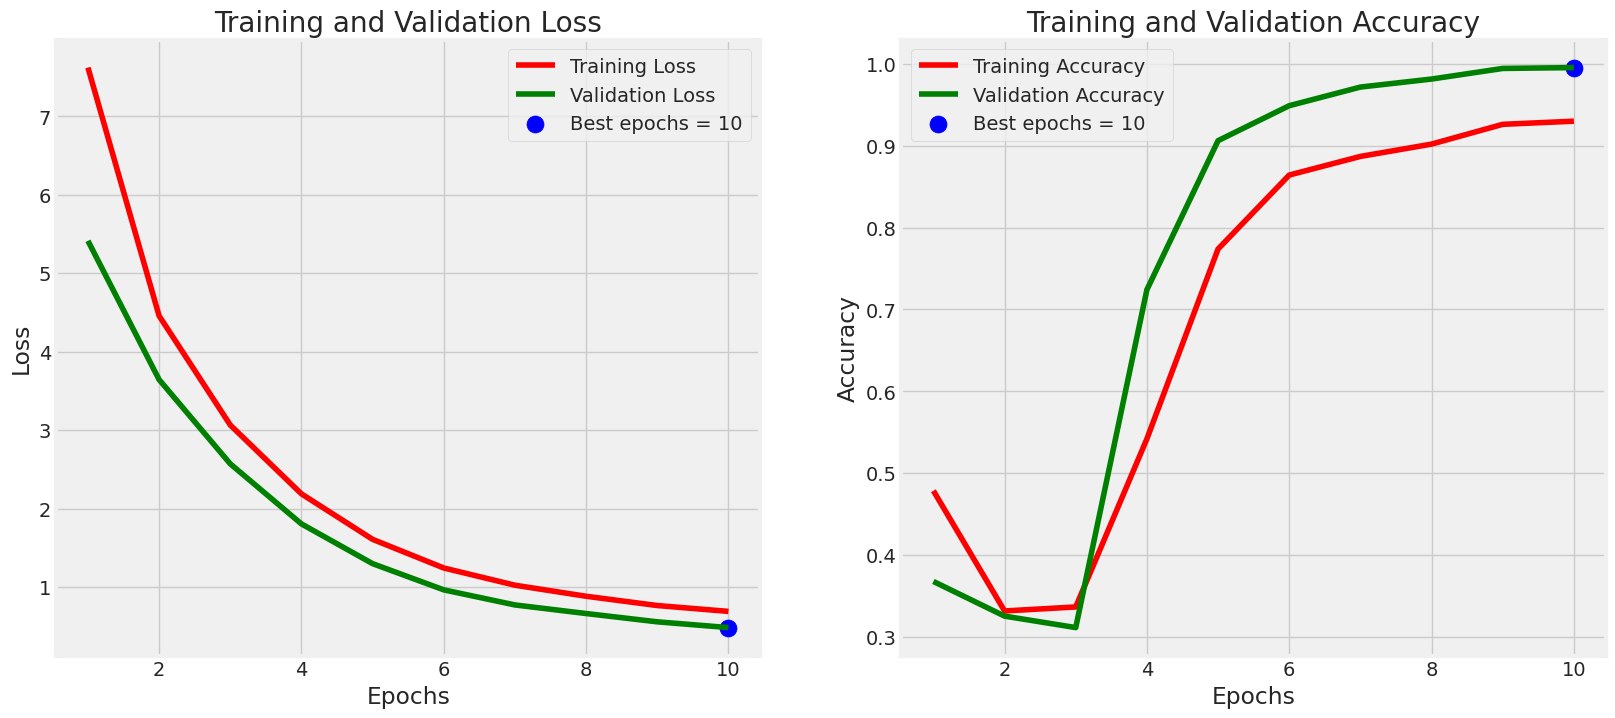

In [55]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [56]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 0.4822
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9929 - loss: 0.4820
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9957 - loss: 0.4881
Train Loss:  0.48698845505714417
Train Accuracy:  1.0
--------------------
Validation Loss:  0.47735774517059326
Validation Accuracy:  0.99609375
--------------------
Test Loss:  0.4873727262020111
Test Accuracy:  0.99609375


In [57]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step


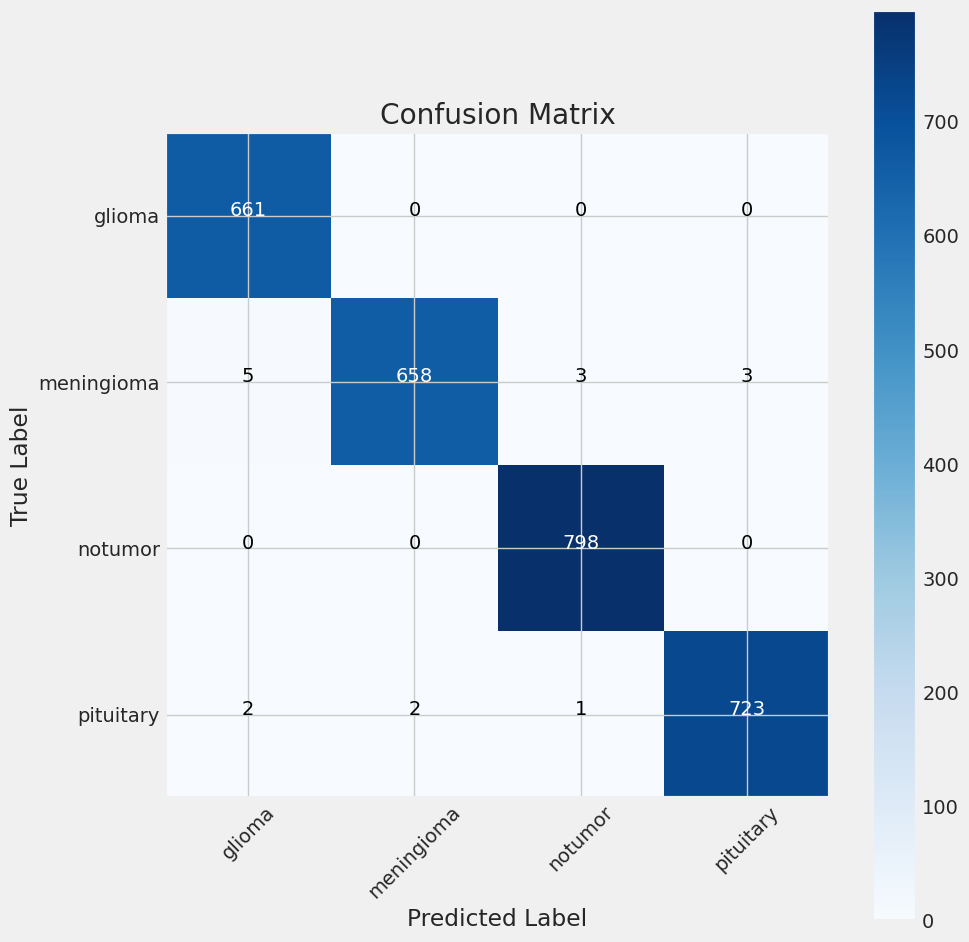

In [58]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [59]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.99      1.00      0.99       661
  meningioma       1.00      0.98      0.99       669
     notumor       1.00      1.00      1.00       798
   pituitary       1.00      0.99      0.99       728

    accuracy                           0.99      2856
   macro avg       0.99      0.99      0.99      2856
weighted avg       0.99      0.99      0.99      2856



In [62]:
model.save("model.h5")

In [63]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [64]:
model = load_model('model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [60]:
gambar = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Colab Notebooks/dataset/Testing/glioma/Te-glTr_0000.jpg', target_size=img_size)

In [65]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [66]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


In [67]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [68]:
print(predicted_class)

[0]


In [69]:
names = [classes[i] for i in predicted_class]
print(names)

['glioma']
